In [ ]:
!pip install --upgrade --quiet networkx

In [19]:
import numpy as np
import seaborn as sns
import networkx as nx
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.preprocessing import scale

plt.rcParams['figure.figsize'] = [10, 5]

In [20]:
def partial_correlation(d, i, j):
    """ Estimate partial correlation between i and j """
    cov = np.cov(d.T)
    s = np.sqrt(np.diag(cov))
    corr = cov / np.outer(s,s)
    om = np.linalg.inv(corr)
    return - om[i,j] / np.sqrt(om[i,i] * om[j,j])

def partial_correlation_ols(d, i, j, z):
    """ Estimate partial correlation between i and j conditional on z"""
    fit = lambda i: sm.OLS(data[:, [i]], data[:, z]).fit()
    return np.corrcoef(fit(i).resid, fit(j).resid)[0,1]

In [21]:
class DAG():
    def __init__(self, tot, avg_children = 3, noise = .5):
        self.noise = noise
        self.lam = avg_children
        self.i = 0
        self.adjacency = np.zeros((tot,tot))
        self.new_children = [0]
        self.tot = tot
        self.nodes = False

    def _shuffle(self, a):
        n = a.shape[0]
        idx = np.random.choice(range(n), size = n, replace=False)
        a = a[idx]
        a = a.T[idx].T
        return a

    def _data(self):
        self.data = np.zeros(self.tot)
        for i,col in enumerate(self.adjacency.T):
            dat = self.data.dot(col)
            if dat == 0:
                dat = np.random.normal(0,1,1)[0]
            self.data[i] = dat + np.random.normal(0,self.noise,1)[0]
        return self.data
    
    def generate_nodes(self):
        """ Implements a breadth-first generation of nodes """
        while self.new_children:
            i = self.new_children.pop()
            left = self.tot - self.i            
            children = np.random.poisson(self.lam, 1)[0]            
            children = children if left - children >= 0 else left
            connections = [self.i + i for i in range(children)]
            
            # Generates random normal 0,1 edges
            self.adjacency[i, connections] = np.random.normal(0, 1, children)
            self.new_children += connections
            self.i += children

        # Retry if we did not get a full graph
        if self.i != self.tot:
            self.__init__(self.tot)
            self.generate_nodes()
        
        # Shuffle to get random indices
        self.adjacency = self._shuffle(self.adjacency)
        self.nodes = True

    
    def generate_data(self, n):
        """ Generates data according to the implied adjacency matrix

        Every node is their parent, times the coefficient in the
        adjacency matrix, plus additive gaussian noise (sd = self.noise).
        """

        if not self.nodes:
            self.generate_nodes()
        dat = np.array([self._data() for i in range(n)])  
        return dat

In [22]:


dag = DAG(40)
data = dag.generate_data(100)

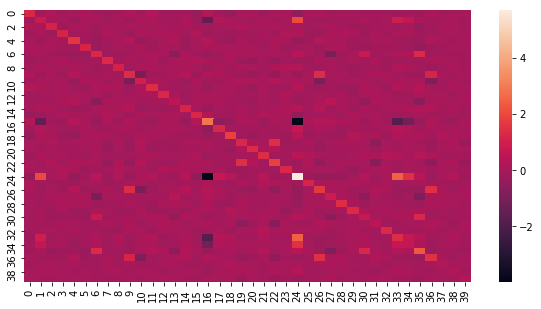

In [23]:
sns.heatmap(np.cov(data.T))

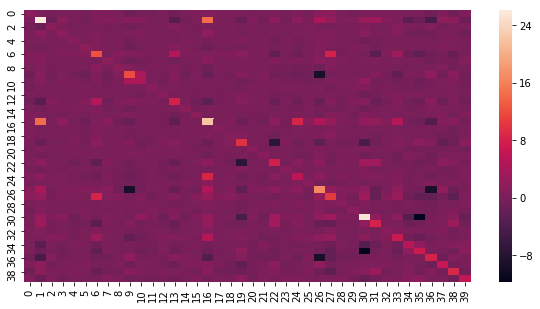

In [24]:
sns.heatmap(np.linalg.inv((np.cov(data.T))))

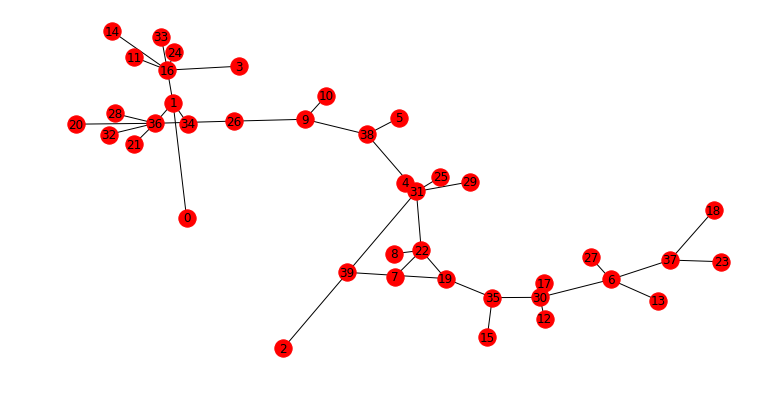

In [29]:
graph = nx.from_numpy_array(np.abs(d.adjacency), create_using = nx.Graph)
nx.draw(graph, with_labels = True)

In [1095]:
# Pick a target variable (y) by looking at the above plot.
# Let the rest of the data be potential predictors

def pick(d, i):
    return d[:, i], np.delete(d, i, 1)

y, X = pick(scale(data), 14)

In [ ]:
# Take a look at the results from OLS. 
# 1. Are they reasonable? 
# 2. Are there any spurious correlations? 

print(sm.OLS(y, X).fit().summary())

In [ ]:
# Given your perfect knowledge of the true DGP,
# pick a reduced form model and run OLS regression. 
# 1. Does this look like a better model? 

In [ ]:
# Clearly, we have a large graph, but we're only interested in 
# the part that is local to our target variable (y).
# Try to find this minimal model via model selection,
# over local linear models: 

In [ ]:
# Take a look at partial correlations between a pair of data points.
# See how this evolves as N (number of observations) grows.

In [ ]:
# Now let's try to recover the ENTIRE precision matrix, 
# via a series of local regressions